<a href="https://colab.research.google.com/github/babalooski/BIOE486/blob/main/HW3_2025_pytorch_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import itertools
from sklearn.metrics import recall_score, precision_score, confusion_matrix

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# Dataset

In [16]:
# The dataset for use in this assignment is a set of chest x-ray images.
# There are three classes - patients diagnosed with COVID, patients with healthy lungs, and patients diagnosed with pneumonia.
# The training dataset consists of 500 COVID images, 3000 normal images, and 3000 pneumonia images.
# The testing dataset is comprised of 300 images of each category.

# GRADING NOTES:
# You are expected to provide a high-level summary of each architecture you implement for tasks 3-6.
# e.g., using summary from torchsummary
# Also ensure that you include accuracy and loss curves for each network, similar to previous HWs.
# In addition to accuracy, also compute the precision and recall metrics
# Reference the most appropriate metrics when performing your analysis.
# Remember presentation is a component of your grading - ensure that your results are neat and concise.

normalization_transform = transforms.Compose([
    transforms.ToTensor(),                     # Convert to tensor and Normalize to [0, 1] range  of shape (C x H x W)
])

train_dir = '/content/drive/MyDrive/covidx/train'  # change this to the dataset location you put in
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=normalization_transform)

test_dir = './drive/MyDrive/covidx/test'  # change this to the dataset location you put in
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=normalization_transform)


In [17]:
# cont'd
# Print PyTorch version
print(f"PyTorch version: {torch.__version__}")
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

# Print information about the datasets
print(f"Number of training classes: {len(train_dataset.classes)}")
print(f"Class names: {train_dataset.classes}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")

PyTorch version: 2.6.0+cu124
Using device cuda:0
Number of training classes: 3
Class names: ['COVID-19', 'normal', 'pneumonia']
Number of training images: 6489
Number of testing images: 300


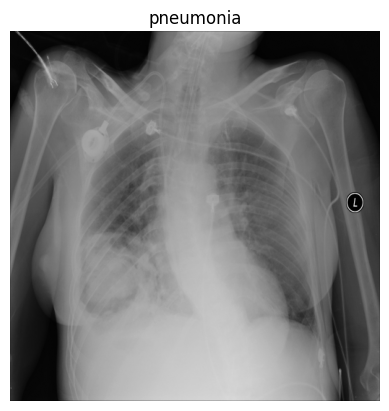

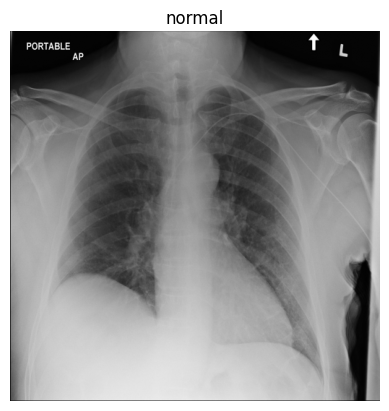

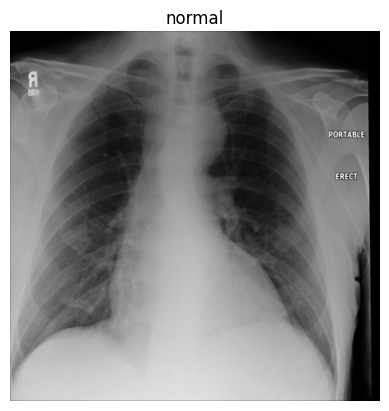

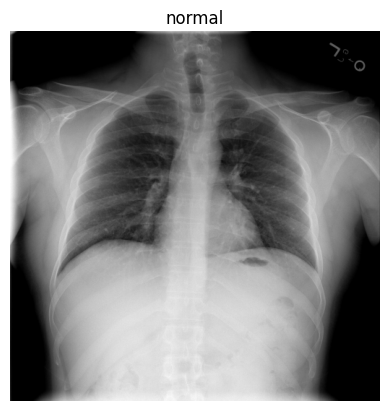

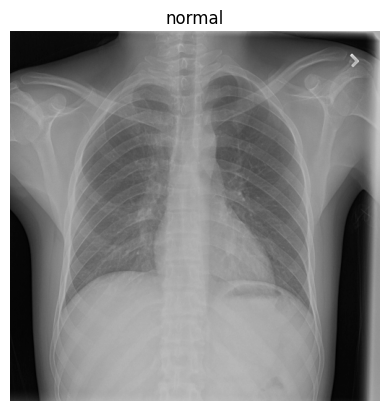

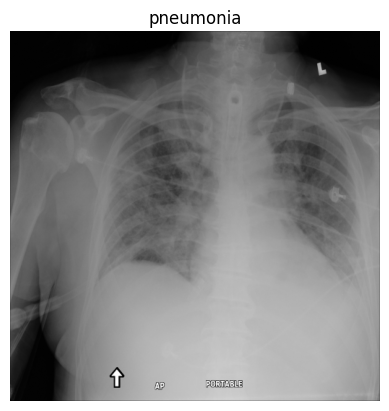

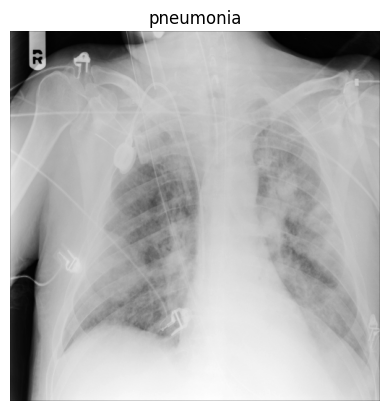

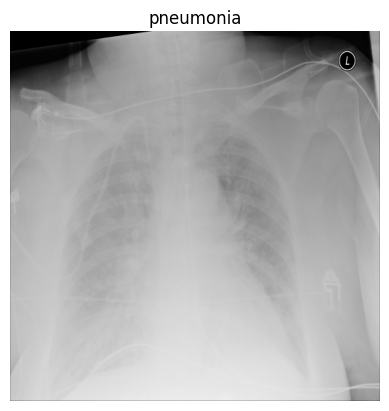

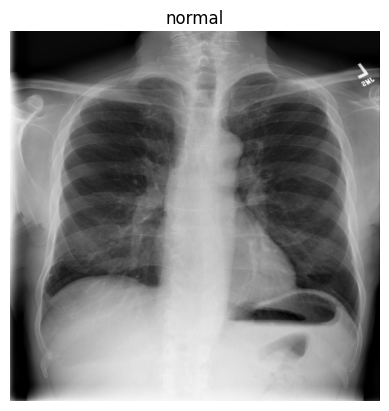

In [18]:
# TASK 1:
# Visualize dataset samples
# Display at least nine images from the training dataset.
# Plot the images as grayscale and include the label as a title above each image.
# Try to achieve that at least one image from each class is displayed.
# Additionally, note your qualitative observations below - can you see what distinguishes the classes?


# Create a DataLoader with batch size 9 to display sample images
train_loader_for_visualization = torch.utils.data.DataLoader(train_dataset, batch_size=9, shuffle=True)

# Get one batch of images
# ----------------------------
# ----------------------------
# Put your codes here
# ----------------------------
# -------------------

grayscale = transforms.Grayscale(num_output_channels=1)

for images, labels in train_loader_for_visualization:
    for image, label in zip(images, labels):
        # Convert the image to
        #image_np = image.numpy().transpose((1, 2, 0))
        gray_image = grayscale(image).numpy().transpose(1,2,0).squeeze()
        plt.imshow(gray_image, cmap='gray')
        plt.title(train_dataset.classes[label])
        plt.axis('off')
        plt.show()
    break


# The pneumonia x-rays have a lot more cloudiness within the lower part of the chest compared to the normal x-rays

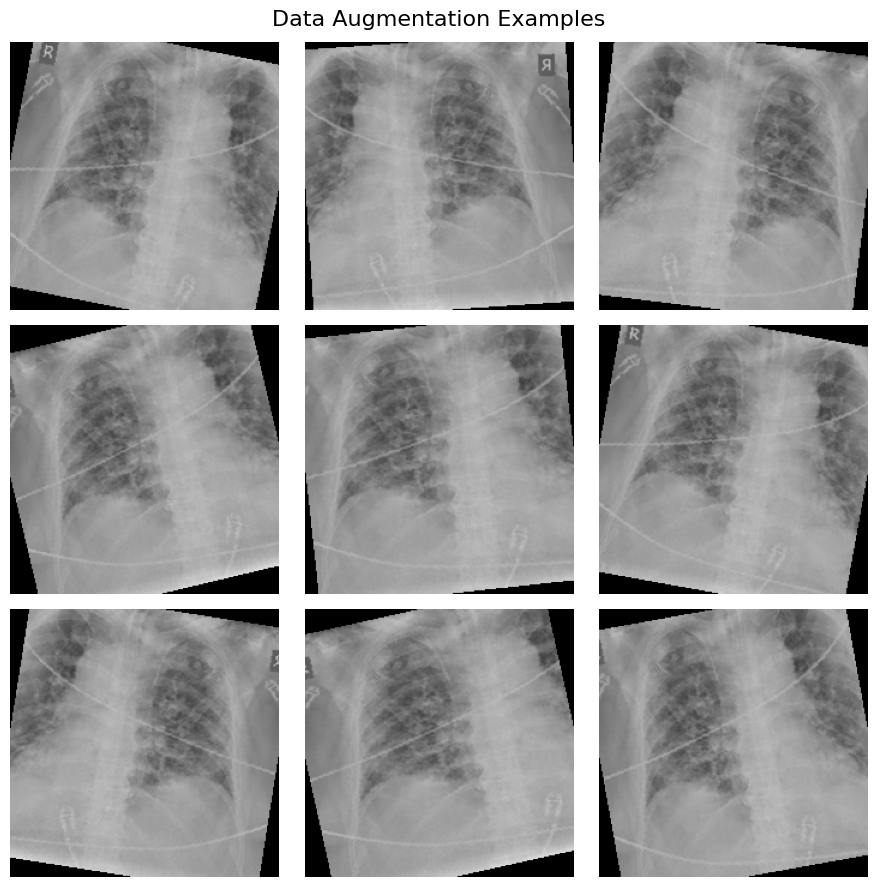

In [19]:
# TASK 2:
# Implement data augmentation.
# One way of increasing training data and making a network more generalizable is to apply data augmentation.
# Implement at least three of the data augmentation techniques described in class.
# There are many ways to do this, with some being much more time intensive than others.
# Display one image augmented nine different times to demonstrate your augmentation pipeline.
# The input to your augmentation is images of size 256x256 in the range [0, 255].
# The output should be images of size 224x224 in the range [0, 1].
# Include a statement on what three data augmentation techniques you selected.

# ----------------------------
# ----------------------------
# Put your codes here
# ----------------------------
# ----------------------------

transform_augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),                    # Random horizontal flip
    transforms.RandomRotation(15),                        # Random rotation within ±15 degrees
    transforms.ToTensor()                                 # Convert to tensor and scale values to [0,1]
])

# ----------------------------
# Load One Real Image for Demonstration
# ----------------------------
# Load the dataset without any transformation
dataset_no_transform = torchvision.datasets.ImageFolder(root=train_dir, transform=None)
dummy_image, _ = dataset_no_transform[0]  # dummy_image is a PIL image
dummy_image = dummy_image.resize((256, 256))  # Ensure the image is 256x256

# Convert the PIL image to a NumPy array (dtype=np.uint8)
# dummy_image_np = np.array(dummy_image)

# ----------------------------
# Display One Image Augmented 9 Times
# ----------------------------
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
fig.suptitle('Data Augmentation Examples', fontsize=16)

for i in range(3):
    for j in range(3):
        augmented = transform_augment(dummy_image)
        img_np = augmented.permute(1, 2, 0).numpy()
        axes[i, j].imshow(img_np)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# ----------------------------
# Create DataLoaders with Augmentation
# ----------------------------
# train_dataset_augmented = torchvision.datasets.ImageFolder(
#     root=train_dir,
#     transform=transform_augment  # Data augmentation applied for training
# )

# # For testing, we use a simpler transform: center crop to 224x224 and convert to tensor.
# test_transform = transforms.Compose([
#     transforms.CenterCrop(224),
#     transforms.ToTensor()
# ])
# test_dataset_augmented = torchvision.datasets.ImageFolder(
#     root=test_dir,
#     transform=test_transform
# )

test_dataset_augmented = torchvision.datasets.ImageFolder(root=train_dir, transform=transform_augment)
train_dataset_augmented = torchvision.datasets.ImageFolder(root=train_dir, transform=transform_augment)

# Create dataLoader with augmentation
train_loader = torch.utils.data.DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset_augmented, batch_size=32, shuffle=False)


# Fetch one batch of images of shape [batch_size, # of channels, h, w]
# ----------------------------
# ----------------------------
# Put your codes here
# ----------------------------
# ----------------------------

In [20]:
# TASK 3:
# Using the convolutional architecture from HW2, train the model to classify the images.
# The single modification to make is to increase the pooling size for all pooling layers to 8 from 2.
# This keeps the number of parameters reasonable.
# Make sure to include data augmentations in your data loaders!
# Analyze the results and describe how useful the network is for identifying COVID cases.



class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # ----------------------------
        # ----------------------------
        # Put your codes here
        # ----------------------------
        # ----------------------------
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=8, stride=8)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=8, stride=8)

        #fcl
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # ----------------------------
        # ----------------------------
        # Put your codes here
        # ----------------------------
        # ----------------------------
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [21]:
# initialize the convolutions according to the activation function
# Fan-out focuses on the gradient distribution, and is commonly used in ResNets
def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            nn.init.constant_(module.bias, 0)


In [22]:
# cont'd
# ----------------------------
# ----------------------------
# Put your codes here to print a summary of your model
# Example below
# ----------------------------
# ----------------------------

from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
         MaxPool2d-6             [-1, 64, 3, 3]               0
            Linear-7                  [-1, 128]          73,856
            Linear-8                    [-1, 3]             387
Total params: 93,827
Trainable params: 93,827
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 25.46
Params size (MB): 0.36
Estimated Total Size (MB): 26.39
----------------------------------------------------------------


In [23]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# trainer function to encapsulate the training and validation process
def train_model(model, criterion, optimizer, train_loader, test_loader, device, num_epochs):
    """
    Trains and validates a machine learning model using a specified training and validation (test) dataset.

    Parameters:
    - model: The neural network model to be trained and evaluated.
    - criterion: The loss function used to evaluate the performance of the model.
    - optimizer: The optimization algorithm used to update the model's weights.
    - train_loader: DataLoader for the training dataset. Provides batches of data for the training phase.
    - test_loader: DataLoader for the validation (test) dataset. Used for evaluating the model.
    - device: The device to use for computation (e.g., 'cuda:0' or 'cpu').
    - num_epochs: The number of epochs (iterations over the entire dataset) to train the model.

    Returns:
    - history: A dictionary containing 'train_loss', 'train_accuracy', 'train_recall', 'train_precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'.
      These metrics are tracked for each epoch.
    """
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_recall': [],
        'train_precision': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_recall': [],
        'val_precision': []
    }
    # Initialize the scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{num_epochs}, Current LR: {current_lr}')

        # Training phase
        # ----------------------------
        # Put your codes here to implement the model training
        # Compute and save the appropriate metrics (see the validation phase codes for examples)
        # Make sure you initialize things (e.g. the model) propertly
        # ----------------------------
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        train_predictions = []
        train_ground_truth = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_predictions.extend(predicted.view(-1).cpu().numpy())
            train_ground_truth.extend(labels.view(-1).cpu().numpy())

        train_accuracy = correct / total
        train_recall = recall_score(train_ground_truth, train_predictions, average='macro')
        train_precision = precision_score(train_ground_truth, train_predictions, average='macro', zero_division=1)



        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        val_predictions = []
        val_ground_truth = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_predictions.extend(predicted.view(-1).cpu().numpy())
                val_ground_truth.extend(labels.view(-1).cpu().numpy())
        val_accuracy = correct / total
        val_recall = recall_score(val_ground_truth, val_predictions, average='macro')
        val_precision = precision_score(val_ground_truth, val_predictions, average='macro', zero_division=1)


        #Update the learning rate
        scheduler.step()

        # Epoch summary
        print(f'Train loss: {train_loss/len(train_loader):.4f} - accuracy: {train_accuracy:.4f} - recall: {train_recall:.4f} - precision: {train_precision:.4f}')
        print(f'Val loss: {val_loss/len(test_loader):.4f} - accuracy: {val_accuracy:.4f} - recall: {val_recall:.4f} - precision: {val_precision:.4f}')

        # Append history
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_accuracy'].append(train_accuracy)
        history['train_recall'].append(train_recall)
        history['train_precision'].append(train_precision)
        history['val_loss'].append(val_loss / len(test_loader))
        history['val_accuracy'].append(val_accuracy)
        history['val_recall'].append(val_recall)
        history['val_precision'].append(val_precision)

    return history

In [24]:
# visualization function which takes the training history, the model,
# and the test loader as input arguments and will plot the accuracy and loss
def plot_training_results(history, model, test_loader, device):
    """
    Plots the training accuracy, loss, and confusion matrix.

    Parameters:
    - history: A dictionary containing 'train_accuracy', 'val_accuracy', 'train_loss', and 'val_loss'.
    - model: The trained model for evaluation.
    - test_loader: DataLoader for the test dataset.
    - device: The device to use for computation (e.g., 'cuda:0' or 'cpu').
    """


    # Plot accuracy
    # ----------------------------
    # ----------------------------
    # Put your codes here
    # ----------------------------
    # ----------------------------
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()



    # Plot loss
    # ----------------------------
    # ----------------------------
    # Put your codes here
    # ----------------------------
    # ----------------------------

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_precision'], label='Train Precision')
    plt.plot(history['val_precision'], label='Validation Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_recall'], label='Train Recall')
    plt.plot(history['val_recall'], label='Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.tight_layout()
    plt.show()

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, preds = torch.max(outputs, 1)
          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

    # Create and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_loader.dataset.classes,
                yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


In [25]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # account for larger batch size
criterion = nn.CrossEntropyLoss()

# Define the dataloaders for training and val/testing with augmentations included
train_loader = torch.utils.data.DataLoader(
    train_dataset_augmented,
    batch_size=128,  # Adjusted batch size
    shuffle=True,
    num_workers=2,  # Adjust based on your system's capability, normally set to 2 for colab
    pin_memory=True  # Enable for faster data transfer to GPU
)

test_loader = torch.utils.data.DataLoader(
    test_dataset_augmented,
    batch_size=32,
    shuffle=False,
    num_workers=2,  # Same as train_loader
    pin_memory=True
)

In [ ]:
num_epochs = 15 # Adjust as needed
history = train_model(model, criterion, optimizer, train_loader, test_loader, device, num_epochs)

Epoch 1/15, Current LR: 0.0005
Train loss: 0.7079 - accuracy: 0.7104 - recall: 0.5122 - precision: 0.4740
Val loss: 0.6446 - accuracy: 0.7443 - recall: 0.5367 - precision: 0.8298
Epoch 2/15, Current LR: 0.0004945369001834514
Train loss: 0.6182 - accuracy: 0.7519 - recall: 0.5467 - precision: 0.7237
Val loss: 0.6455 - accuracy: 0.7648 - recall: 0.5514 - precision: 0.8446
Epoch 3/15, Current LR: 0.00047838636441065017
Train loss: 0.5885 - accuracy: 0.7630 - recall: 0.5695 - precision: 0.7721
Val loss: 0.5707 - accuracy: 0.7747 - recall: 0.5683 - precision: 0.8332
Epoch 4/15, Current LR: 0.0004522542485937369
Train loss: 0.5490 - accuracy: 0.7829 - recall: 0.5998 - precision: 0.8123
Val loss: 0.5313 - accuracy: 0.7869 - recall: 0.6016 - precision: 0.8417
Epoch 5/15, Current LR: 0.0004172826515897146
Train loss: 0.5276 - accuracy: 0.7932 - recall: 0.6232 - precision: 0.7989
Val loss: 0.5170 - accuracy: 0.7987 - recall: 0.6004 - precision: 0.8378
Epoch 6/15, Current LR: 0.000375
Train loss:

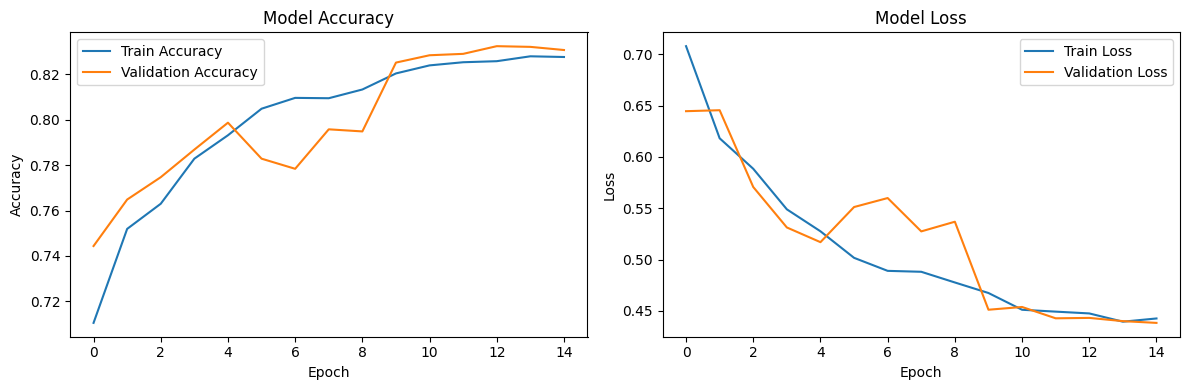

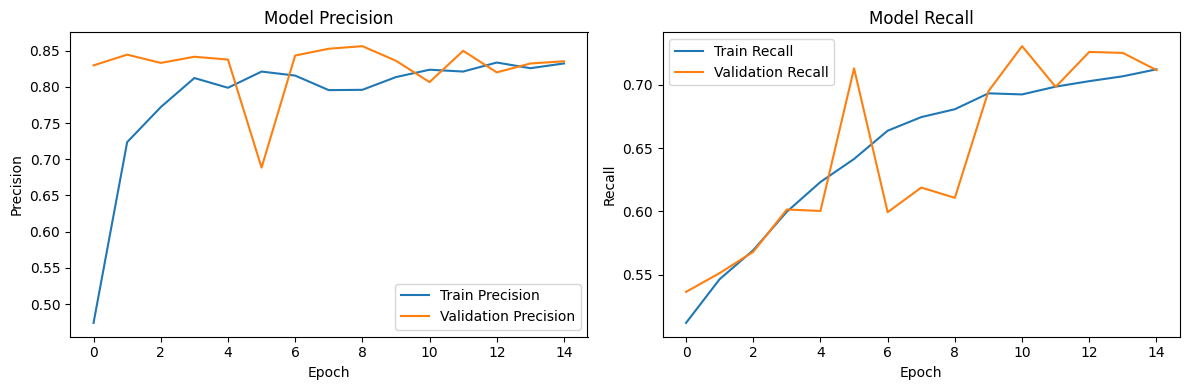

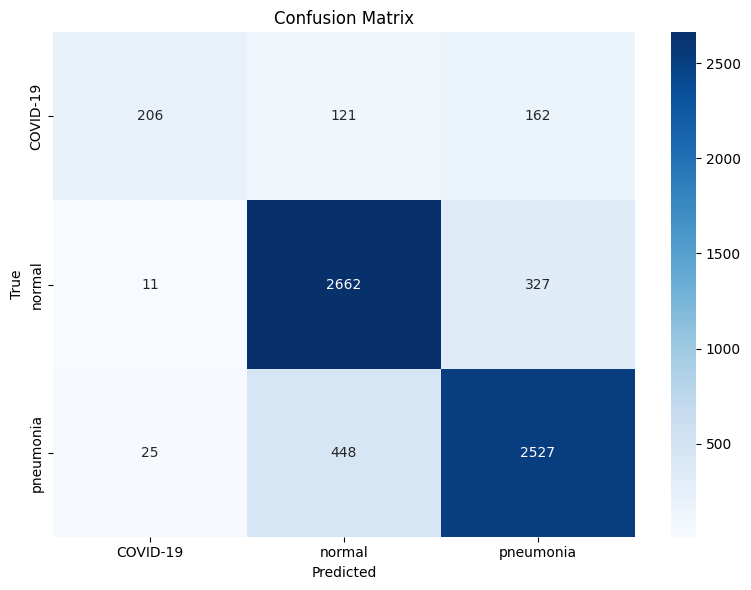

In [ ]:
plot_training_results(history, model, test_loader, device)

# This model is useful in predicting covid-19 cases because it determines the difference between pneumonia patients and patients with no conditions


In [27]:
# TASK 4:
# Implement class balancing.
# There are many methods of adjusting for biased distributions of classes.
# Pick one, describe it, and implement it.
# Evaluate your method on the same model as in task 3.
# Include observations on how well your selected method worked.

# Empty the CUDA cache (if using GPU)
if torch.cuda.is_available():
    torch.cuda.empty_cache()


# ----------------------------
# ----------------------------
# Put your codes here
# ----------------------------
# ----------------------------



train_dataset_counts = [500, 3000, 3000]  # [COVID, normal, pneumonia] counts
total_samples = sum(train_dataset_counts)
class_weights = torch.tensor([total_samples / (3 * count) for count in train_dataset_counts], device=device)


# Update the Loss function post class balancing, if your loss function needs to be updated
# Note: whether the loss needs to be updated DEPENDS on your balancing strategy
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))


model = ConvNet()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=7e-4)


# reinitialize the model weights
initialize_weights(model)




In [ ]:
num_epochs = 15
history = train_model(model, criterion, optimizer, train_loader, test_loader, device, num_epochs)

Epoch 1/15, Current LR: 0.0007
Train loss: 1.0242 - accuracy: 0.5653 - recall: 0.5416 - precision: 0.5097
Val loss: 0.7030 - accuracy: 0.7124 - recall: 0.5194 - precision: 0.6979
Epoch 2/15, Current LR: 0.000692351660256832
Train loss: 0.7774 - accuracy: 0.6812 - recall: 0.6640 - precision: 0.6034
Val loss: 1.4665 - accuracy: 0.3074 - recall: 0.4944 - precision: 0.6235
Epoch 3/15, Current LR: 0.0006697409101749102
Train loss: 0.6942 - accuracy: 0.7104 - recall: 0.7079 - precision: 0.6318
Val loss: 0.9787 - accuracy: 0.5489 - recall: 0.6531 - precision: 0.6277
Epoch 4/15, Current LR: 0.0006331559480312316
Train loss: 0.6332 - accuracy: 0.7433 - recall: 0.7424 - precision: 0.6620
Val loss: 0.6508 - accuracy: 0.7332 - recall: 0.7432 - precision: 0.6561
Epoch 5/15, Current LR: 0.0005841957122256004
Train loss: 0.6340 - accuracy: 0.7460 - recall: 0.7387 - precision: 0.6636
Val loss: 1.1560 - accuracy: 0.4757 - recall: 0.6140 - precision: 0.6345
Epoch 6/15, Current LR: 0.000525
Train loss: 0

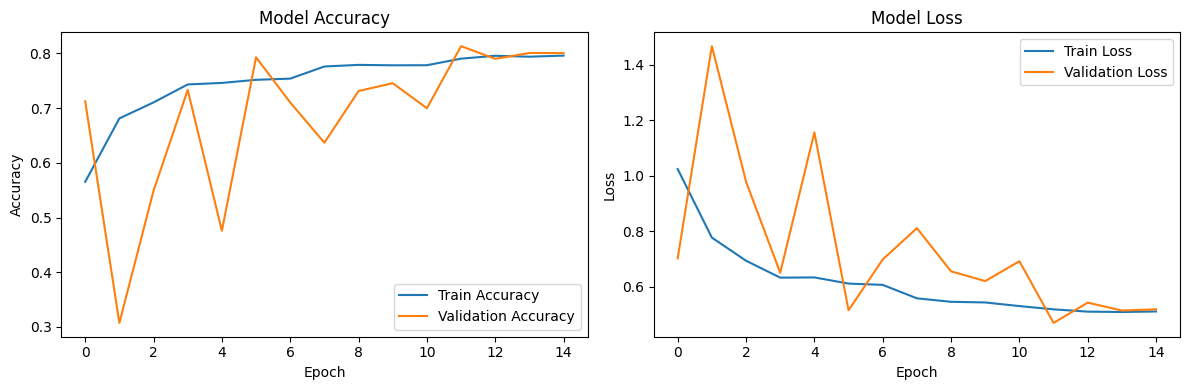

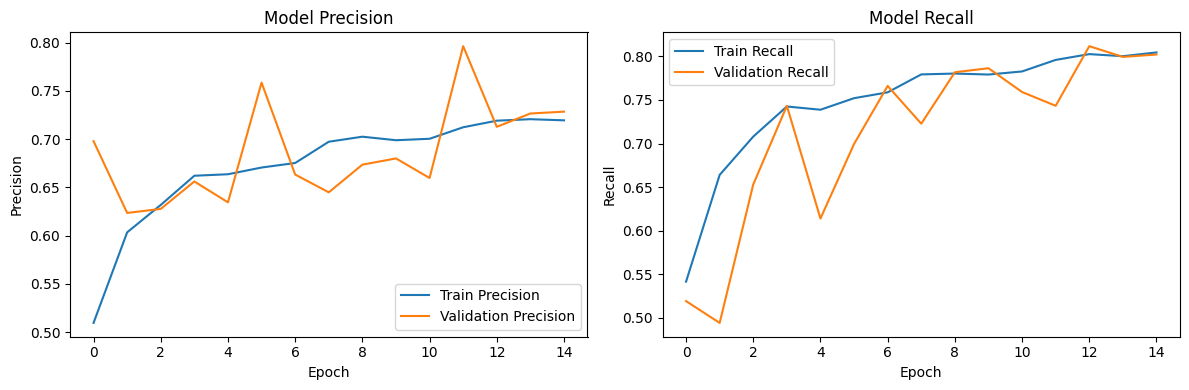

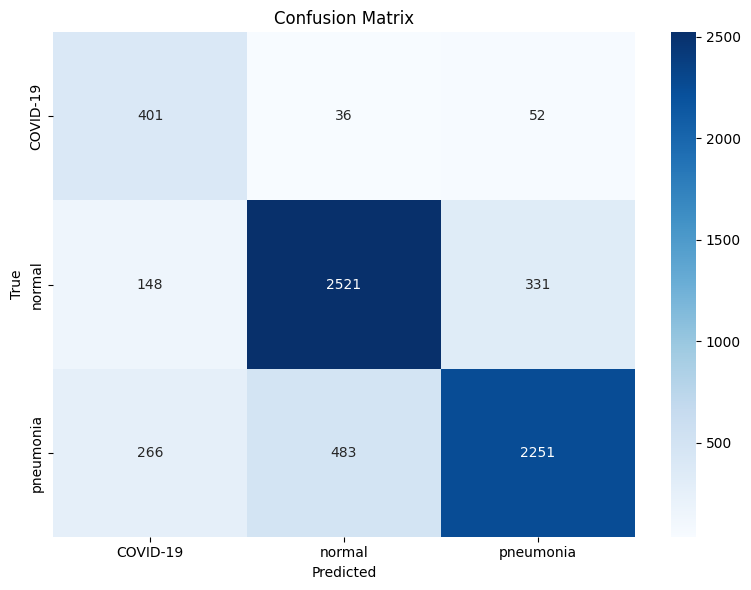

In [ ]:
plot_training_results(history, model, test_loader, device)

#this model is much better at predicting covid cases however will give many more false positives than the previous model however it has a lower overall accuracy in terms of overall predictions between all categories

In [ ]:
# TASK 5: GRADUATE CREDIT
# Improve network performance.
# Change the network architecture to attempt to improve on the performance from task 4.
# Describe the improvements you made to the network and the observed impact on accuracy.
# Your goal is to hit a test accuracy above 0.73.
# The top 3 submissions in terms of performance in test accuracy will be rewarded with extra credit (10 pts) and the opportunity to share your techniques with the class.

In [28]:
# TASK 6:
# Use transfer learning with MobileNet2 (a lightweight ResNet https://arxiv.org/pdf/1801.04381.pdf).
# Transfer learning is a method of adapting networks trained on related problems to apply them to new ones.
# Here, we will a network trained on the ImageNet dataset to classify the chest x-ray images.

# Tips for initializing and loading MobileNetV2:
#   Import the MobileNetV2 model with default weights from torchvision.models (use MobileNet_V2_Weights.DEFAULT).
#   Remove the top classification layer as it is specific to ImageNet's 1000 classes.
#   Attach a new classifier layer tailored to the classification problem to match the number of output classes.

# You will have to transform the data, as this network expects data in the range of [-1, 1]
# Include both data augmentation and your improvements from Task 4.
# Do not include the architecture of MobileNet2 when presenting your solution.
# Only include the overall pipeline, including your additions.
# Your goal is to hit a test accuracy above 0.76.
# How does the network compare with your previous implementations?

# The network has a lower accuracy than the previous implementations as it does not seem to predict any covid cases especially as compared to the other previous implementations

# ImageNet images look quite different than the chest x-ray images - why does transfer learning work here, even without retraining?

# Empty the CUDA cache (if using GPU)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Normalize dataset to [-1, 1] range to suit MobileNet
# ----------------------------
# ----------------------------
# Put your codes here
# ----------------------------
# ----------------------------

# Load the dataset with the transformation for mobileNet
# ----------------------------
# Put your codes here
# ----------------------------

mobilenet_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),       # Random crop for augmentation
    transforms.RandomHorizontalFlip(),         # Random flip for augmentation
    transforms.ToTensor(),                     # Convert PIL image to tensor [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalize to [-1, 1]
                         std=[0.5, 0.5, 0.5])
])

# For testing/validation, use deterministic transforms.
mobilenet_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

train_dataset_mobilenet = torchvision.datasets.ImageFolder(root=train_dir, transform=mobilenet_train_transform)
test_dataset_mobilenet = torchvision.datasets.ImageFolder(root=test_dir, transform=mobilenet_test_transform)

# Optionally, create DataLoaders for batching:
train_loader = torch.utils.data.DataLoader(train_dataset_mobilenet, batch_size=32, shuffle=True)
test_loader_ = torch.utils.data.DataLoader(test_dataset_mobilenet, batch_size=32, shuffle=False)



# train_transforms = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
#     transforms.Resize((256, 256)),
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
# ])
# test_transforms = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])
# # ----------------------------
# # Load the dataset with the transformation for MobileNet
# # ----------------------------
# train_dataset_augmented = datasets.ImageFolder(root=train_dir, transform=train_transforms)
# test_dataset_augmented  = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# # ----------------------------
# # Create DataLoader with augmentation for MobileNet
# # ----------------------------
# # First, a simple DataLoader (you may remove this if you don't need it)

# # Create dataLoader with augmentation for mobileNet
# # train_loader = torch.utils.data.DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
# # test_loader = torch.utils.data.DataLoader(test_dataset_augmented, batch_size=32, shuffle=False)


# # Define the dataloaders for training and val/testing for mobileNet
# train_loader = torch.utils.data.DataLoader(
#     train_dataset_augmented,
#     batch_size=128,  # Adjusted batch size
#     shuffle=True,
#     num_workers=2,  # Adjust based on your system's capability, normally set to 2 for colab
#     pin_memory=True  # Enable for faster data transfer to GPU
# )

# test_loader = torch.utils.data.DataLoader(
#     test_dataset_augmented,
#     batch_size=32,
#     shuffle=False,
#     num_workers=2,  # Same as train_loader
#     pin_memory=True
# )


In [29]:
# cont'd -- set up modified pretrained MobileNetV2 model, loss function and optimizer
#   Model Loading:
#     Import and load pre-trained MobileNetV2 with MobileNet_V2_Weights.DEFAULT.
#     Freeze the pre-trained parameters by setting requires_grad to False for each parameter in base_model.parameters().
#   Classifier Modification:
#     Replace the original classifier with a new one matching your task's classes (e.g., 3 classes for chest X-ray images).
#   Loss Function and Optimizer:
#     Use a weighted loss function if dealing with class imbalance.
#     Choose Adam optimizer with an initial learning rate, like 5e-4.


# ----------------------------
# ----------------------------
# Put your codes here
# ----------------------------
# ----------------------------

import torchvision.models as models
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
base_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

# Freeze all pre-trained parameters to prevent them from updating during training
for param in base_model.parameters():
    param.requires_grad = False

# Replace the classifier:
# The original classifier is a Sequential with [Dropout, Linear(1280 -> 1000)].
# We modify it to output 3 classes.
in_features = base_model.classifier[1].in_features
base_model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, 3)
)

# Move the modified model to the device (GPU if available)
model = base_model.to(device)

# ----------------------------
# Loss Function and Optimizer Setup
# ----------------------------
# Suppose we have computed class weights for our imbalanced dataset.
# For example, assume the weights for the 3 classes are as follows:
#class_weights = torch.tensor([1.0, 2.0, 1.5], dtype=torch.float).to(device)

# Use a weighted CrossEntropyLoss to penalize misclassification of the minority class more heavily
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer with an initial learning rate of 5e-4.
# We optimize only the classifier parameters since the base model's parameters are frozen.
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=5e-4)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 65.6MB/s]


In [30]:
num_epochs = 15
history = train_model(model, criterion, optimizer, train_loader, test_loader, device, num_epochs)

Epoch 1/15, Current LR: 0.0005
Train loss: 0.6660 - accuracy: 0.7442 - recall: 0.5405 - precision: 0.6264
Val loss: 0.6603 - accuracy: 0.7625 - recall: 0.5498 - precision: 0.8416
Epoch 2/15, Current LR: 0.0004945369001834514
Train loss: 0.5427 - accuracy: 0.7838 - recall: 0.6142 - precision: 0.8294
Val loss: 0.6156 - accuracy: 0.7719 - recall: 0.5742 - precision: 0.8371
Epoch 3/15, Current LR: 0.00047838636441065017
Train loss: 0.5196 - accuracy: 0.7941 - recall: 0.6633 - precision: 0.8206
Val loss: 0.6170 - accuracy: 0.7702 - recall: 0.5742 - precision: 0.8115
Epoch 4/15, Current LR: 0.0004522542485937369
Train loss: 0.4978 - accuracy: 0.7990 - recall: 0.6771 - precision: 0.8102
Val loss: 0.6136 - accuracy: 0.7724 - recall: 0.5797 - precision: 0.8184
Epoch 5/15, Current LR: 0.0004172826515897146
Train loss: 0.4895 - accuracy: 0.8083 - recall: 0.6992 - precision: 0.8190
Val loss: 0.6065 - accuracy: 0.7762 - recall: 0.5905 - precision: 0.8129
Epoch 6/15, Current LR: 0.000375
Train loss:

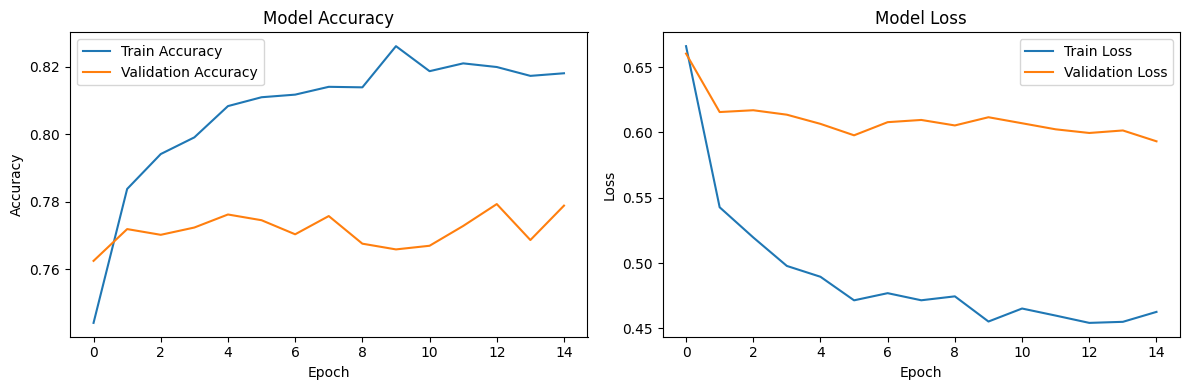

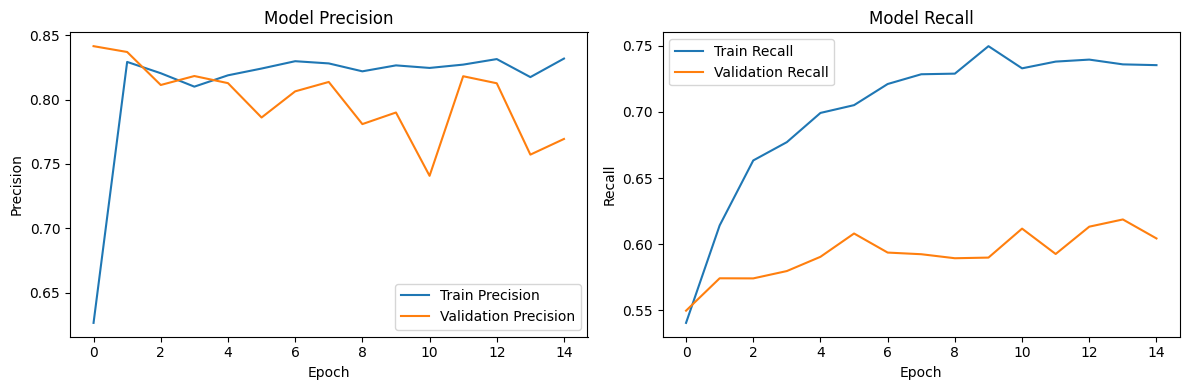

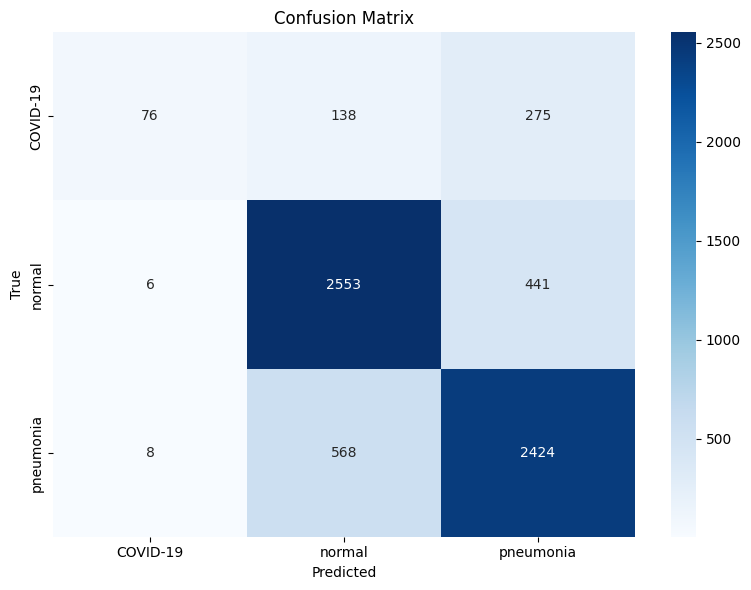

In [31]:
plot_training_results(history, model, test_loader, device)


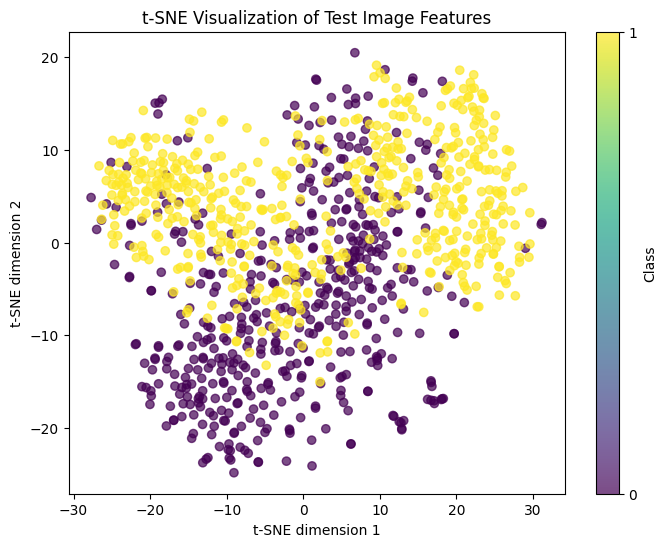

In [32]:
# TASK 7: Extra Credits
# Use a dimensionality reduction technique (preferrably nonlinear) to visualize the feature vectors from the last fully-connected layer in Task 6 (for a range of test images).
# You may want to color code your low-dimensional features corresponding to different classes (e.g., assigning one color to the points from the same class and a different color for another class)
# Record your observations about the pattern of the low-dimensional features.

from sklearn.manifold import TSNE

def extract_features(model, loader, device, max_samples=1000):
    """
    Extract features from the test dataset using the pretrained MobileNetV2's feature extractor.
    We use the features output by model.features followed by a global average pooling.

    Parameters:
      model: The pretrained MobileNetV2 model.
      loader: DataLoader to iterate over the test images.
      device: The device to perform computations on.
      max_samples: Maximum number of samples to extract (to speed up t-SNE).

    Returns:
      features: Array of extracted feature vectors.
      labels: Corresponding class labels.
    """
    model.eval()
    features = []
    labels_list = []
    count = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # Extract features using the feature extractor.
            # For MobileNetV2, the forward pass is usually:
            #   x = model.features(images)   --> output shape: (batch, channels, H, W)
            #   x = x.mean([2,3])            --> global average pooling to shape: (batch, channels)
            x = model.features(images)
            x = x.mean([2, 3])
            features.append(x.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            count += images.size(0)
            if count >= max_samples:
                break

    features = np.concatenate(features, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    return features, labels_list

# Example: Extract features from up to 1000 test images.
features, labels = extract_features(model, test_loader, device, max_samples=1000)

# Use t-SNE to reduce the high-dimensional features to 2D.
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot the 2D features with color coding for each class.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization of Test Image Features")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.colorbar(scatter, ticks=range(len(np.unique(labels))), label="Class")
plt.show()